In [1]:
from IPython.display import clear_output
!pip install imutils
clear_output()

In [2]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import shuffle

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
from tensorflow import keras


init_notebook_mode(connected=True)
RANDOM_SEED = 123

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [4]:
IMG_PATH = '../Internship/data/brain_tumor/raw/'

# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
    for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
        img = IMG_PATH + CLASS + '/' + FILE_NAME
        if n < 5:
            shutil.copy(img, '../Internship/data/brain_tumor/' + 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
        elif n < 0.8*IMG_NUM:
            shutil.copy(img, '../Internship/data/brain_tumor/' + 'TRAIN/' + CLASS.upper() + '/' + FILE_NAME)
        else:
            shutil.copy(img, '../Internship/data/brain_tumor/' + 'VAL/' + CLASS.upper() + '/' + FILE_NAME)

In [5]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    for yesorno in (sorted(os.listdir(dir_path))):
        for imgname in os.listdir(dir_path + yesorno):
            img = cv2.imread(dir_path + yesorno + '/' + imgname)
            X.append(img)
            if yesorno=='NO':
              y.append(0)
            else:
              y.append(1)
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [6]:
BASE_DIR = '../Internship/data/brain_tumor/'
TRAIN_DIR = BASE_DIR + 'TRAIN/'
TEST_DIR = BASE_DIR + 'TEST/'
VAL_DIR = BASE_DIR + 'VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val = load_data(VAL_DIR, IMG_SIZE)

C:\Users\Siddhanth\AppData\Local\Temp\ipykernel_22572\1197329414.py:15: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



193 images loaded from ../Internship/data/brain_tumor/TRAIN/ directory.
10 images loaded from ../Internship/data/brain_tumor/TEST/ directory.
50 images loaded from ../Internship/data/brain_tumor/VAL/ directory.


In [7]:
y_val

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

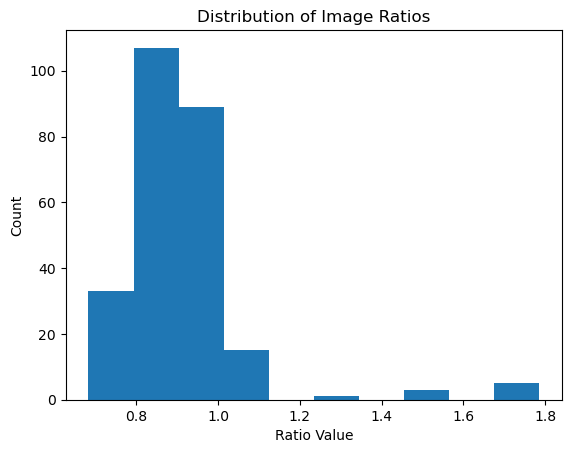

In [8]:
RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])
        
plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

In [9]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [10]:
img = cv2.imread('../Internship/data/brain_tumor/raw/yes/Y108.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

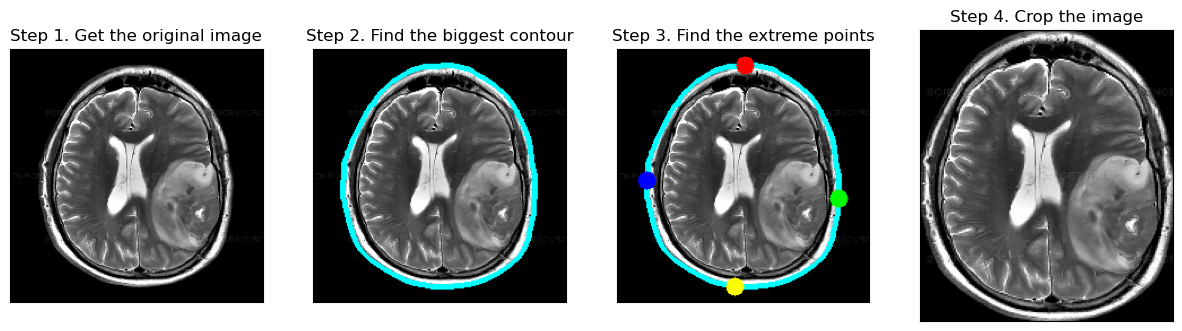

In [11]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [12]:
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

C:\Users\Siddhanth\AppData\Local\Temp\ipykernel_22572\2254567846.py:31: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



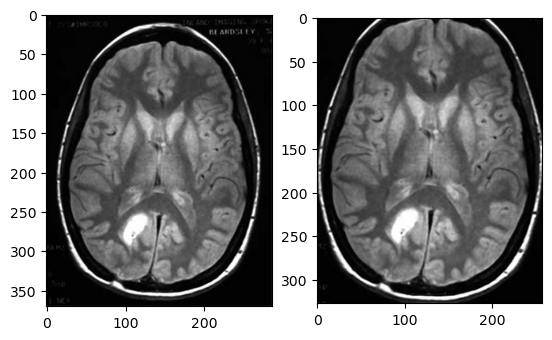

In [13]:
i = 100

plt.subplot(121)
plt.imshow(X_train[i])

plt.subplot(122)
plt.imshow(X_train_crop[i])

In [14]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [15]:
# saving new images to the folder

save_new_images(X_train_crop, y_train, folder_name=BASE_DIR+'TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name=BASE_DIR+'VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name=BASE_DIR+'TEST_CROP/')

In [16]:
print(len(os.listdir(BASE_DIR+'TRAIN_CROP/YES')))
print(len(os.listdir(BASE_DIR+'TRAIN_CROP/NO')))
print(len(os.listdir(BASE_DIR+'TEST_CROP/YES')))
print(len(os.listdir(BASE_DIR+'TEST_CROP/NO')))
print(len(os.listdir(BASE_DIR+'VAL_CROP/YES')))
print(len(os.listdir(BASE_DIR+'VAL_CROP/NO')))

193
74
10
5
50
19


In [17]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(img,dsize=img_size,interpolation=cv2.INTER_CUBIC)
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [18]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)


X_train_prep,y_train = shuffle(X_train_prep,y_train,random_state=0)
X_test_prep,y_test = shuffle(X_test_prep,y_test,random_state=0)
X_val_prep,y_val = shuffle(X_val_prep,y_val,random_state=0)

In [19]:
y_train

array([1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1])

In [20]:
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

In [21]:
x = X_train_crop[0]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir=BASE_DIR+'preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 

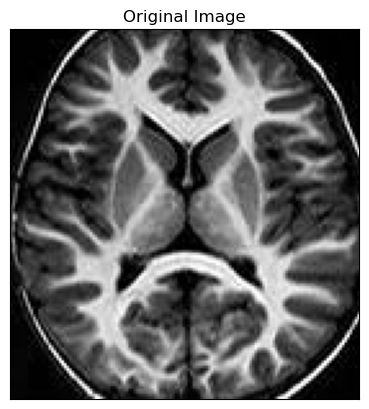

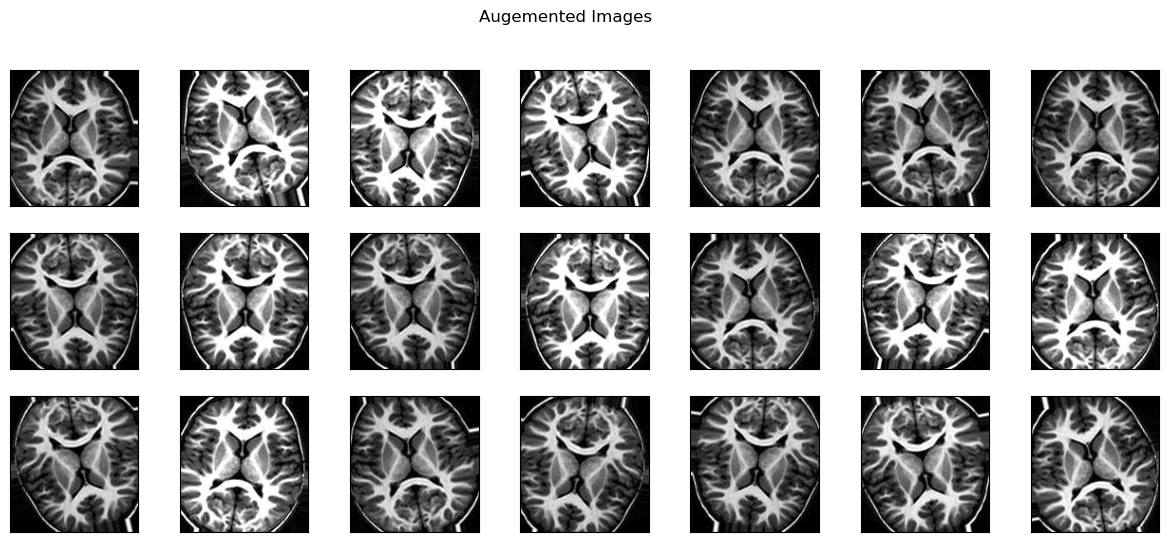

In [22]:
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir(BASE_DIR+'preview/'):
    img = cv2.imread(BASE_DIR+'preview/'+img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [23]:
TRAIN_DIR = BASE_DIR+'TRAIN_CROP/'
VAL_DIR = BASE_DIR+'VAL_CROP/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='binary'
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='binary',
)

Found 267 images belonging to 2 classes.
Found 69 images belonging to 2 classes.


In [24]:
train_generator.samples

267

In [25]:
vgg16_weight_path = r"C:\Users\Siddhanth\Internship\data\brain_tumor\Pretrained Models\vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
base_model = VGG16(
    weights=vgg16_weight_path,
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

In [26]:
model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


C:\Users\Siddhanth\anaconda3\envs\ev_2\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



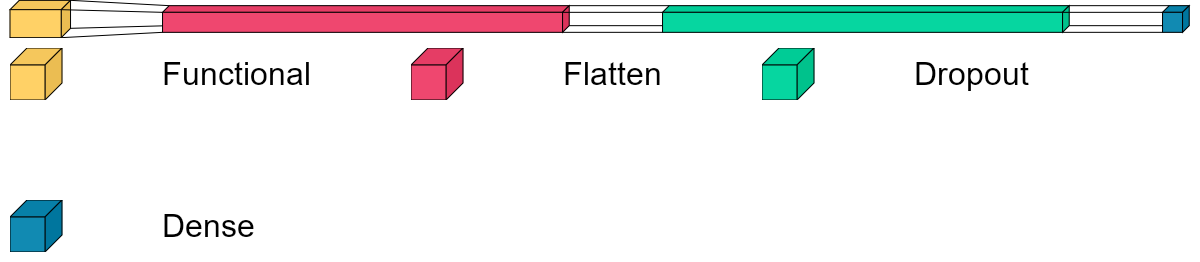

In [27]:
import visualkeras
from PIL import ImageFont

font = ImageFont.truetype("arial.ttf", 32)

visualkeras.layered_view(model, legend=True, font=font, spacing=100)

In [28]:
EPOCHS = 30
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=6
)

history = model.fit_generator(
    train_generator,
    steps_per_epoch = 193,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=50
)


C:\Users\Siddhanth\anaconda3\envs\ev_2\lib\site-packages\keras\engine\training.py:1972: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/30
193/193 [==============================] - 12s 35ms/step - loss: 6.7848 - accuracy: 0.4715 - val_loss: 2.2750 - val_accuracy: 0.7000
Epoch 2/30
193/193 [==============================] - 6s 30ms/step - loss: 5.4633 - accuracy: 0.6114 - val_loss: 2.5801 - val_accuracy: 0.7200
Epoch 3/30
193/193 [==============================] - 6s 29ms/step - loss: 3.7646 - accuracy: 0.7098 - val_loss: 2.6027 - val_accuracy: 0.6600
Epoch 4/30
193/193 [==============================] - 6s 29ms/step - loss: 5.0855 - accuracy: 0.6010 - val_loss: 1.5417 - val_accuracy: 0.7400
Epoch 5/30
193/193 [==============================] - 6s 30ms/step - loss: 4.6692 - accuracy: 0.6580 - val_loss: 1.1735 - val_accuracy: 0.7600
Epoch 6/30
193/193 [==============================] - 6s 32ms/step - loss: 5.5959 - accuracy: 0.6269 - val_loss: 2.0627 - val_accuracy: 0.7400
Epoch 7/30
193/193 [==============================] - 6s 32ms/step - loss: 4.9825 - accuracy: 0.6321 - val_loss: 2.0020 - val_accuracy: 0.680

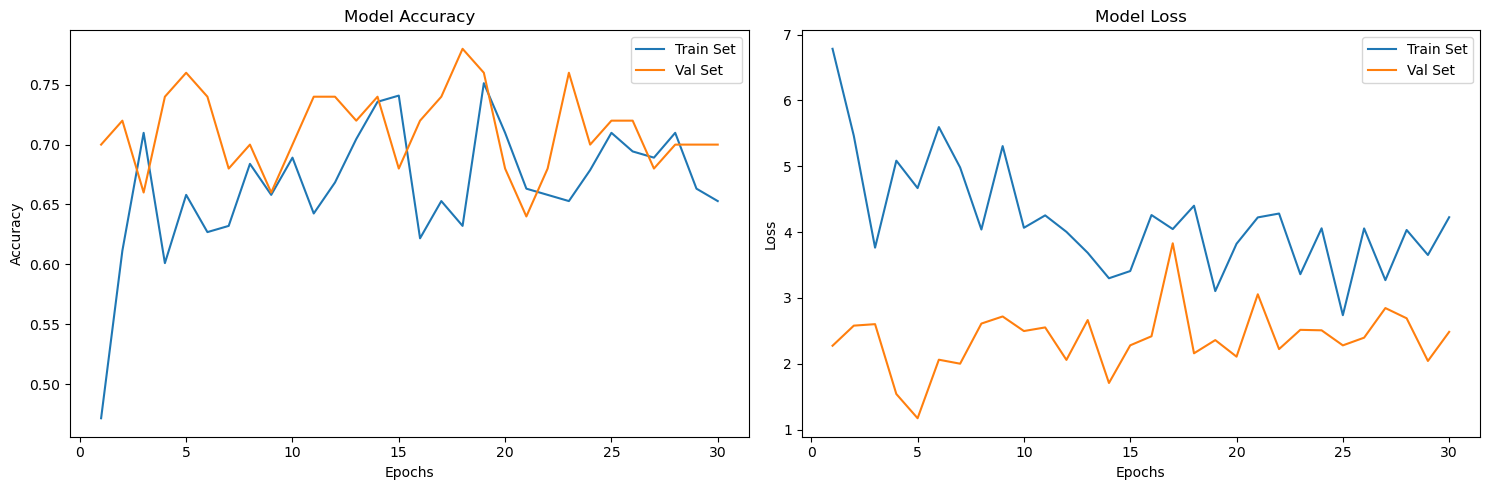

In [29]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

Val Accuracy = 0.80


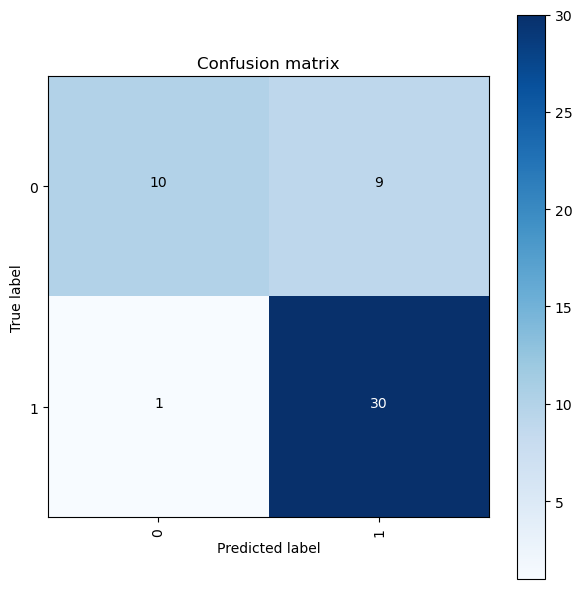

In [30]:
# validate on val set
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = [0,1], normalize=False)

Test Accuracy = 0.90


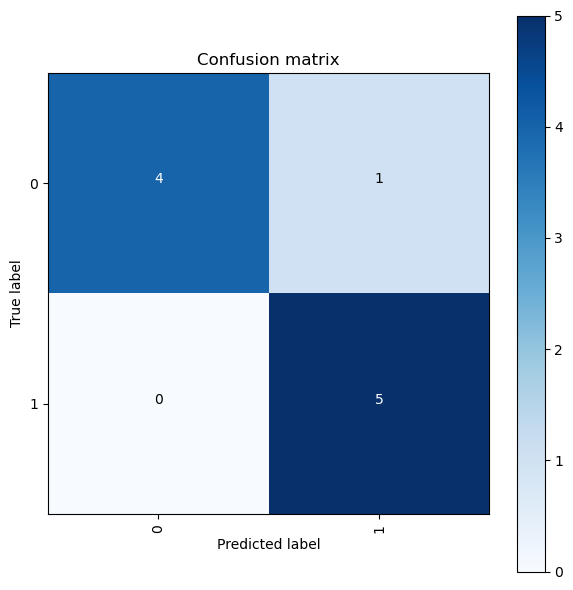

In [31]:
# validate on test set
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = [0,1], normalize=False)

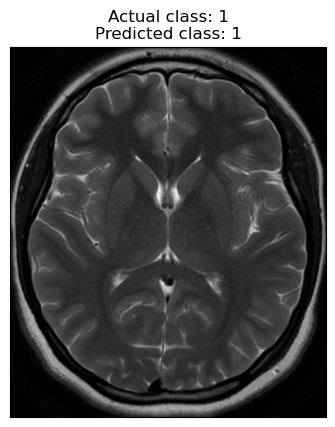

In [32]:
ind_list = np.argwhere((y_test == predictions) == False)[:, -1]
if ind_list.size == 0:
    print('There are no missclassified images.')
else:
    for i in ind_list:
        plt.figure()
        plt.imshow(X_test_crop[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Actual class: {y_val[i]}\nPredicted class: {predictions[i]}')
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


No Tumor


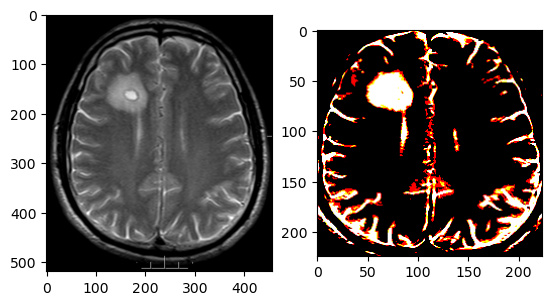

In [34]:
IMG_SIZE = (224,224)

# live test

model = keras.models.load_model('../Internship/models/brain_tumor_model.h5', compile = False)
testimgpath = '../Internship/data/brain_tumor/raw/yes/Y3.jpg'

def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(img,dsize=img_size,interpolation=cv2.INTER_CUBIC)
        set_new.append(preprocess_input(img))
    return np.array(set_new)



def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)


#read
plt.subplot(121)
test_img = cv2.imread(testimgpath)
plt.imshow(test_img)

#resize
# plt.subplot(132)
# test_img = cv2.resize(test_img,dsize=IMG_SIZE,interpolation=cv2.INTER_CUBIC)
# plt.imshow(test_img)

#crop and resize and preprocess for vgg
plt.subplot(122)
test_img = crop_imgs([test_img])
test_img = test_img.reshape(test_img.shape[1:])
test_img = preprocess_imgs([test_img],IMG_SIZE)
plt.imshow(test_img.reshape(test_img.shape[1:]))

#make prediction
pred = model.predict(test_img)
if pred<0.5:
    print('No Tumor')
else:
    print('Brain is having the tumor')

In [35]:
ind_list = np.argwhere((y_test == predictions) == False)[:, -1]
ind_list

array([0], dtype=int64)

In [ ]:
model.save("../Internship/models/brain_tumor_model.h5")